In [1]:
from estnltk import Text

from pandas import read_csv
from estnltk.taggers import RegexTagger

from estnltk.spans import Span, SpanList
from estnltk.layer import Layer
from estnltk.finite_grammar.layer_graph import print_nodes
import csv
from estnltk.finite_grammar import PhraseListTagger

from estnltk.taggers.gaps_tagging.gaps_tagger import GapsTagger
from estnltk.taggers.merge_tagging.merge_tagger import MergeTagger

from estnltk.layer_operations.flatten import flatten

from estnltk.finite_grammar.layer_graph import layer_to_graph, plot_graph
from estnltk.finite_grammar.grammar import parse_graph
#from estnltk.finite_grammar.layer_graph import graph_to_parse_trees

import re

In [2]:
specification = [
    ('parem',),
    ('vasak',), 
    ('eesmine',),
    ('tagumine',),
    ('külgmine',)
    ]

In [3]:
bodypart = [
    ('neer',),
    ('põlv',), 
    ('kops',),
    ('aju',),
    ('külgvatsake',)
    ]

In [4]:
def specification_decorator(text, span, phrase):
    return {'match': phrase, 'grammar_symbol': 'SPECIFICATION', 
            'form': str(span.form), 'partofspeech': str(span.partofspeech)}

In [5]:
specification_tagger = PhraseListTagger(layer_name='specification',
                              input_layer = 'morph_analysis',
                               input_attribute='lemma',
                             phrase_list=specification,
                               decorator = specification_decorator,
                             attributes=('match', 'grammar_symbol', 'form', 'partofspeech'),
                             conflict_resolving_strategy= 'MAX'
                              )

In [6]:
def bodypart_decorator(text, span, phrase):
    return {'match': phrase, 'grammar_symbol': 'BODYPART', 
            'form': str(span.form), 'partofspeech': str(span.partofspeech)}

In [7]:
bodypart_tagger = PhraseListTagger(layer_name='bodypart',
                              input_layer = 'morph_analysis',
                               input_attribute='lemma',
                             phrase_list=bodypart,
                               decorator = bodypart_decorator,
                             attributes=('match', 'grammar_symbol', 'form', 'partofspeech'),
                             conflict_resolving_strategy= 'MAX'
                              )

In [8]:
taggers = {}
taggers['bodypart_tagger'] = bodypart_tagger
#taggers['location_tagger'] = location_tagger
taggers['specification_tagger'] = specification_tagger

In [9]:
def gaps_decorator(text:str):
    return {'gap_length':len(text), 'grammar_symbol': 'RANDOM_TEXT'}

In [10]:
def trim(text):
    t_1 = re.sub('\s*', '', text)
    t_1 = re.sub('\s+(on|oli)\s+', '', t_1)
    
    return t_1

In [11]:
gaps_tagger = GapsTagger(layer_name='gaps',
                         input_layers=['bodypart', 
                                       #'location_tagger',
                                       'specification'
                                       ],
                         trim=trim, 
                         decorator=gaps_decorator,
                         attributes=['grammar_symbol'])

In [12]:
merge_tagger = MergeTagger(layer_name='grammar_tags',
                           input_layers=['bodypart',
                                       #'location_tagger',
                                         'specification',
                                      'gaps'],
                           attributes=('grammar_symbol', 'value', 'form', 'partofspeech'))

In [13]:
def tag_sent(sent):
    sent = Text(sent)
    sent.analyse('morphology')
    for tagger in taggers:
        taggers[tagger].tag(sent)
        #temp_layer = taggers[tagger].tag(sent, return_layer = True)
        #sent[tagger] = flatten(temp_layer, tagger)
        #sent[tagger] = temp_layer
    gaps_tagger.tag(sent)
    merge_tagger.tag(sent)
    return sent

In [14]:
i = 'vasakus põlves valu'

In [15]:
j = tag_sent(i)

In [16]:
j

Text(text="vasakus põlves valu")

In [17]:
j.grammar_tags

SL[SL[SL[Span(vasakus, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'vasak', 'partofspeech': 'A', 'root': 'vasak', 'root_tokens': ('vasak',)})]],
SL[SL[Span(põlves, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'põli', 'partofspeech': 'S', 'root': 'põli', 'root_tokens': ('põli',)}),
Span(põlves, {'clitic': '', 'ending': 's', 'form': 'sg in', 'lemma': 'põlv', 'partofspeech': 'S', 'root': 'põlv', 'root_tokens': ('põlv',)})]],
SL[SL[Span(valu, {'clitic': '', 'ending': '0', 'form': 'sg p', 'lemma': 'valu', 'partofspeech': 'S', 'root': 'valu', 'root_tokens': ('valu',)})]]]

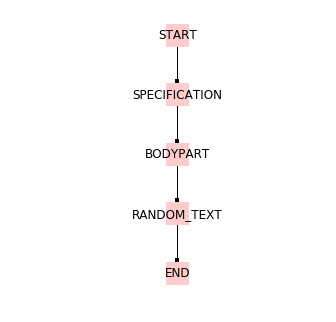

In [18]:
graph = layer_to_graph(j['grammar_tags'])
plot_graph(graph,4)

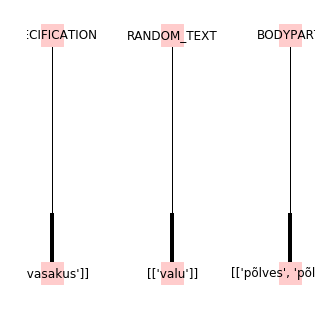

In [19]:
plot_graph(graph.parse_trees, 4)